# Modélisation de la propagation de l'épidémie du Covid : Simulation multi-agents

Sources : 

Lien utile pour l'utilisation de la mémoire dans une classe en Python :
https://habr.com/en/post/458518/ 

Lien utile pour la réduction de la mémoire dans un dataset :
https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

Lien utile pour la réduction de la mémoire dans un array numpy : https://pythonspeed.com/articles/numpy-memory-footprint/

Lien pour la population française selon l'age et le sexe en 2020 : https://www.insee.fr/fr/statistiques/2381474

Lien pour l'obésite en France en 2012 : https://www.roche.fr/fr/innovation-recherche-medicale/decouverte-scientifique-medicale/cardio-metabolisme/enquete-nationale-obepi-2012.html

Lien pour les groupes sanguins en France : https://www.ints.fr/SangTransfGrSanguin.aspx

In [1]:
# Librairies utilisées :
import numpy as np
import csv 
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sys
import time 

## Test 1 : allocation mémoire des différents types d'array Python

In [3]:
# Test sur l'allocation en mémoire de différents type d'array :
import sys
import time

i = 10
while i <= 10_000:
    nb_agents = i
    temps_debut = time.time()
    agentList = []
    age = {}
    poids = np.array([])

    with open('agents.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["age", "poids"])
        for i in range(nb_agents):
            writer.writerow([random.randint(1,100) , random.randint(1,100)])


    graph = nx.barabasi_albert_graph(nb_agents, 1) 
    matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))

    class Agent:
        def __init__(self, id_number, accointances) :
            self.id_number = id_number
            self.accointances = accointances
            self.has_it = False

    # Initialize accointances based on the matrix
    for i in range(nb_agents):
        agentList.append(Agent(i, np.nonzero(matrix[i])[0]))

    agents = import_data('./agents.csv',False)

    for i in range(nb_agents):
        age[agentList[i]] = agents['age'][i]
        poids = np.append(poids, agents['poids'][i])

    temps_fin = time.time()
    print(f"Pour {nb_agents} agents :")
    print(f"Le temps d'exécution est de {round(temps_fin-temps_debut,4)}s")
    print("Taille en mémoire de {}:",sys.getsizeof(age))
    print("Taille en mémoire de []:",sys.getsizeof(agentList))
    print("Taille en mémoire de numpy.array:",sys.getsizeof(poids))
    #print("Taille en mémoire de matrix:",sys.getsizeof(matrix))
    #print("Taille en mémoire de sparse_matrix:",sys.getsizeof(sparse_matrix))
    print("\n")

    i = i*10 + 10

Pour 10 agents :
Le temps d'exécution est de 0.038s
Taille en mémoire de {}: 360
Taille en mémoire de []: 184
Taille en mémoire de numpy.array: 176


Pour 100 agents :
Le temps d'exécution est de 0.0254s
Taille en mémoire de {}: 4696
Taille en mémoire de []: 904
Taille en mémoire de numpy.array: 896


Pour 1000 agents :
Le temps d'exécution est de 0.0513s
Taille en mémoire de {}: 36960
Taille en mémoire de []: 9016
Taille en mémoire de numpy.array: 8096


Pour 10000 agents :
Le temps d'exécution est de 1.3456s
Taille en mémoire de {}: 295000
Taille en mémoire de []: 87616
Taille en mémoire de numpy.array: 80096




Observations : 
* Un array numpy prend beaucoup moins de place qu'un dictionnaire ou qu'un array python.
* Le graphe utilisé n'a pas d'impact sur la mémoire, uniquement sur le temps d'exécution

Problèmes : 
* avec 100_000 agents on atteint une limite pour notre graph et on ne peut pas faire `nx.to_numpy_matrix`
`MemoryError: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64`
* Il semblerait que pour créer la matrice, il faut, pour chaque float64, allouer ~8MB de mémoire, comme notre matrice est 100_000*100_000 = 10e9, donc on arrive aux alentours de 80GB de mémoire requis ce qui est impossible ([@source](https://stackoverflow.com/questions/61631553/how-to-handle-memory-errors-with-adjacency-matrix))

Solutions:
* Convertir les edges en int
* Remplacer `nx.to_numpy_matrix` par `nx.to_scipy_sparse_matrix`
* Utiliser un array sparse (uniquement les valeurs non nulles seront définies, les autres seront sur 0 => donc on alloue de la mémoire uniquement pour les valeurs définies non nulles)
* Mettre le bon type sur notre graphe
* Utilisation d'un autre package pour le traitement des graphes par exemple `graph-tool` [@performances](https://graph-tool.skewed.de/performance) ou encore `igraph` 

## Test 2 : importation âge/sexe et vérification des probabilités

Source : [age et sexe](https://www.insee.fr/fr/statistiques/2381474), [poids](https://www.roche.fr/fr/innovation-recherche-medicale/decouverte-scientifique-medicale/cardio-metabolisme/enquete-nationale-obepi-2012.html), [groupe sanguin](https://www.ints.fr/SangTransfGrSanguin.aspx)

In [2]:
# Pour l'âge : 
# 0 = < 15 ans
# 1 = entre 15 et 30 ans
# 2 = entre 30 et 55 ans
# 3 = > 55 ans

# Pour le sexe :
# 0 = homme
# 1 = femme

# Pour le poids :
# 0 = Dénutrition (IMC < 18.5)
# 1 = Normal (18.5 > IMC > 25)
# 2 = Surpoids (25 > IMC > 30)
# 3 = Obésité (IMC > 30)

# Pour le groupe sanguin : 
# 0 = A+
# 1 = O+
# 2 = B+ 
# 3 = AB+
# 4 = A-
# 5 = O-
# 6 = B-
# 7 = AB-

temps_debut = time.time()

nb_agents = 10_000
agentList = []
age=[]
sexe=[]
poids = []
groupe_sanguin = []

# Proportions cumulatives pour l'âge:
prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

# Par tranches d'âges les proportions normalisées sont :
prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

# Proportions cumulatives pour le poids :
prop_poids = [0.035,0.492,0.323,0.15]

# Proportions pour le groupe sanguin : 
prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

graph = nx.barabasi_albert_graph(nb_agents,1)
# Avec numpy array :
matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))

class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

# Initialize accointances based on the matrix
for i in range(nb_agents):
    #agentList.append(Agent(i, np.nonzero(matrix[i].A1)[0]))
    agentList.append(Agent(i,np.nonzero(matrix[i])[0]))


for i in range(nb_agents):
    if 0 <= i <= int(nb_agents*prop_age[0]):
        age.append(0)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
    if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
        age.append(1)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
    if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
        age.append(2)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
    if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
        age.append(3)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
    poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
    groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

temps_fin = time.time()
print(f"Le temps d'exécution est de {round(temps_fin-temps_debut,4)}s\n")
print(f"Il y a {nb_agents} agents.")
print(f"Les tableaux ont la taille du nombre d'agents : {len(age) == len(poids) == len(sexe) == nb_agents}\n")
y = np.bincount(age)/nb_agents
ii = np.nonzero(y)[0]
print(f"La proportion par tranches d'âge est :\n{np.vstack((ii,y[ii])).T}")
y = np.bincount(sexe)/nb_agents
ii = np.nonzero(y)[0]
print(f"La proportion H/F est de :\n{np.vstack((ii,y[ii])).T}")
y = np.bincount(poids)/nb_agents
ii = np.nonzero(y)[0]
print(f"La proportion par poids est de :\n{np.vstack((ii,y[ii])).T}")
y = np.bincount(groupe_sanguin)/nb_agents
ii = np.nonzero(y)[0]
print(f"La proportion pour les groupes sanguins est de :\n{np.vstack((ii,y[ii])).T}")

Le temps d'exécution est de 2.6447s

Il y a 10000 agents.
Les tableaux ont la taille du nombre d'agents : True

La proportion par tranches d'âge est :
[[0.     0.1781]
 [1.     0.1732]
 [2.     0.3176]
 [3.     0.3311]]
La proportion H/F est de :
[[0.     0.5035]
 [1.     0.4965]]
La proportion par poids est de :
[[0.     0.034 ]
 [1.     0.4967]
 [2.     0.3202]
 [3.     0.1491]]
La proportion pour les groupes sanguins est de :
[[0.     0.3744]
 [1.     0.365 ]
 [2.     0.0771]
 [3.     0.0317]
 [4.     0.0745]
 [5.     0.0578]
 [6.     0.0099]
 [7.     0.0096]]


En comparant avec les données des sources, on observe que les proportions obtenues sont correctes.

## Test 3 : simulation multi-agents

Source : [age et sexe](https://www.insee.fr/fr/statistiques/2381474), [poids](https://www.roche.fr/fr/innovation-recherche-medicale/decouverte-scientifique-medicale/cardio-metabolisme/enquete-nationale-obepi-2012.html), [groupe sanguin](https://www.ints.fr/SangTransfGrSanguin.aspx)

In [4]:
# Création de la classe multi-agents

class SMA:
    def __init__(self, nb_agents, adjacency_matrix):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[0.90,0.10])[0])

        # Initialisation des paramètres se basant sur les sources :

        # Pour l'âge : 
        # 0 = < 15 ans
        # 1 = entre 15 et 30 ans
        # 2 = entre 30 et 55 ans
        # 3 = > 55 ans

        # cf. pop-sexe-age-prop.xls 
        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Pour le sexe :
        # 0 = homme
        # 1 = femme

        # Pour le poids :
        # 0 = Dénutrition (IMC < 18.5)
        # 1 = Normal (18.5 > IMC > 25)
        # 2 = Surpoids (25 > IMC > 30)
        # 3 = Obésité (IMC > 30)

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Pour le groupe sanguin : 
        # 0 = A+
        # 1 = O+
        # 2 = B+ 
        # 3 = AB+
        # 4 = A-
        # 5 = O-
        # 6 = B-
        # 7 = AB-

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")

In [5]:
# Création de la classe Agent

class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False
    
    # TO DO :
    # La decision effectue un tour de parole sur tous les agents 
    # L'agent sélectionné regarde alpha personnes de son réseau
    # Parmi ces alpha-personnes, chacunes à beta chance de contaminer notre agent
    # Il faut prendre en compte le gamma-guerison comme quoi une personne contaminé est guérie

    def decide(self, tick) :
        if self.has_it:
            chosen = random.randint(0,len(sma.agentList)-1)

            self.has_it = False
            sma.agentList[random.randint(0,len(sma.agentList)-1)].has_it = parole

            print(f"L'agent {self.id_number} ({sma.sexe[self.id_number]}) pèse {sma.poids[self.id_number]} et est de groupe sanguin {sma.groupe_sanguin[self.id_number]} ! Il parle à l'agent {chosen}.")

In [6]:
# Exécution de la simulation
nb_agents = 10_000
nb_rounds = 5
temps_debut = time.time()

# Choix du type de graphe : 

graph = nx.barabasi_albert_graph(nb_agents, 1) # BA(n,m) avec n le nombre de noeuds et m le nombre d'arc ?
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)


matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix)

# On donne la parole
parole = "J'ai la parole."
an_agent = np.random.choice(sma.agentList)
an_agent.has_it = parole
print(f"Il y a {nb_agents} agents et {nb_rounds} tours.")

# On lance le jeu
sma.run(nb_rounds)

temps_fin = time.time()
print(f"\nLe temps d'exécution est de {round(temps_fin-temps_debut,4)}s.")

# On reprend la balle, pour une éventuelle réexécution.
for agent in sma.agentList:
    if agent.has_it:
        agent.has_it = False

Il y a 10000 agents et 5 tours.
L'agent 5552 (1) pèse 1 et est de groupe sanguin 1 ! Il parle à l'agent 9705.
L'agent 7040 (1) pèse 3 et est de groupe sanguin 4 ! Il parle à l'agent 7157.
L'agent 6706 (1) pèse 3 et est de groupe sanguin 4 ! Il parle à l'agent 3727.
L'agent 463 (0) pèse 1 et est de groupe sanguin 4 ! Il parle à l'agent 1869.
L'agent 8513 (1) pèse 3 et est de groupe sanguin 0 ! Il parle à l'agent 1242.
L'agent 4277 (1) pèse 1 et est de groupe sanguin 1 ! Il parle à l'agent 3354.
L'agent 315 (1) pèse 2 et est de groupe sanguin 1 ! Il parle à l'agent 7414.
L'agent 9239 (0) pèse 3 et est de groupe sanguin 0 ! Il parle à l'agent 5405.

Le temps d'exécution est de 3.4101s.


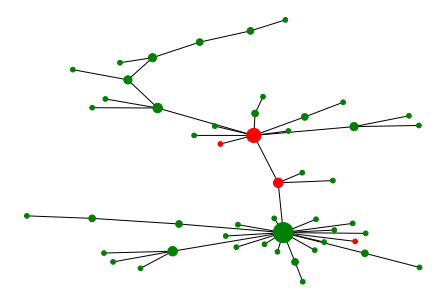

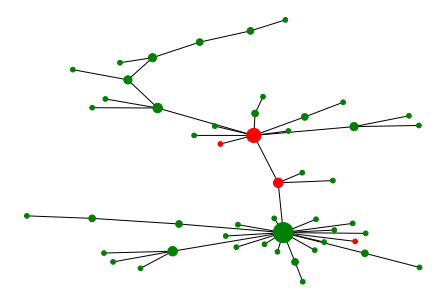

In [14]:
# Tracé des graphes sociaux sur une population plus petite
nb_agents = 50 # 50 est optimal pour le graphe, sinon les tailles sont trop disproportionné

# Choix du type de graphe : 

graph = nx.barabasi_albert_graph(nb_agents, 1) # BA(n,m) avec n le nombre de noeuds et m le nombre d'arc ?

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix)

color_map = []
for node in graph:
    if sma.malade[node] == 1:
        color_map.append('red')
    else: 
        color_map.append('green')  

size =  []
for node in graph:
    size.append(graph.degree(node))

max_value = np.max(size)
iterator = 0
for value in size:
    size[iterator] = (value/max_value)*400
    iterator += 1

my_pos = nx.spring_layout(graph, seed = 100)
    
plt.figure()
nx.draw(graph, pos=my_pos, node_color=color_map, node_size=size)
plt.axis('off')
plt.show()

plt.figure()
nx.draw(graph, pos=my_pos, node_color=color_map, node_size=size)
plt.axis('off')
plt.show()

## Test 4 : mise en place de l'expérience suivant des facteurs de contagion

In [5]:
# Utilisation du graphe dans la classe Agent avec import dans la classe SMA :
class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[0.90,0.10])[0])

        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        prop_poids = [0.035,0.492,0.323,0.15] 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 

In [8]:
# Explications sur la manière de récupèrer les contacts dans la classe Agent
class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    # Comment avoir les contacts d'une personne ? 

    # IF malade = 1 DO np.random.choice([0,1], 1, p=[1-beta,beta])[0]

    def decide(self, tick) :
        # La decision effectue un tour de parole sur tous les agents 
        # L'agent sélectionné regarde alpha personnes de son réseau
        # Parmi ces alpha-personnes, chacunes à beta chance de contaminer notre agent
        # Il faut prendre en compte le gamma-guerison comme quoi une personne contaminé est guérie
        alpha = 0.8
        beta = 0.1
        gamma = 0.1

        if self.has_it:
            # Pour chaque agents j 
            for j in range(0,len(sma.agentList)):
                print(f"Les liens de l'agent {j} sont : {list(sma.graphe.edges(j))}")
                liens = []
                contact = []
                for i in range(0,len(list(graph.edges(j)))):
                    # print(list(graph.edges(j))[i][1])
                    # On récupère les agents en lien avec notre agent
                    # On les met dans un tableau
                    liens.append(list(graph.edges(j))[i][1])
                print(f"L'agent {j} a {len(liens)} liens")
                print(f"Le dernier lien est : {liens[len(liens)-1]}")
                # On récupère aléatoirement alpha % de ces personnes
                print(f"On garde {alpha} % de liens donc : {int(alpha*len(liens))} contact")
                for k in range(int(alpha*len(liens))):
                    valeur_contact = random.randint(0,int(alpha*len(liens)))
                    print(f"On récupère la personne {valeur_contact} dans la liste")
                    contact.append(liens.pop(valeur_contact))
                    print(f"Liens après {k} itérations : {liens}")
                    print(f"Contact à {k} itérations : {contact}")
                # On fait en sorte que chaque j agents est au moins 1 contact :
                if (contact == []):
                    contact.append(liens[len(liens)-1])
                print(f"Au final, les contacts sont : {contact}\n")

In [9]:
# On relance notre expérience 
nb_agents = 10
nb_rounds = 2

# Choix du type de graphe : 
graph = nx.barabasi_albert_graph(nb_agents, 1) # BA(n,m) avec n le nombre de noeuds et m le nombre d'arc ?

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph)

# On donne la parole
parole = "J'ai la parole."
an_agent = np.random.choice(sma.agentList)
an_agent.has_it = parole
print(f"Il y a {nb_agents} agents et {nb_rounds} tours.")

# On lance le jeu
sma.run(nb_rounds)

Il y a 10 agents et 2 tours.
Les liens de l'agent 0 sont : [(0, 1), (0, 3)]
L'agent 0 a 2 liens
Le dernier lien est : 3
On garde 0.8 % de liens donc : 1 contact
On récupère la personne 1 dans la liste
Liens après 0 itérations : [1]
Contact à 0 itérations : [3]
Au final, les contacts sont : [3]

Les liens de l'agent 1 sont : [(1, 0), (1, 2), (1, 4), (1, 7)]
L'agent 1 a 4 liens
Le dernier lien est : 7
On garde 0.8 % de liens donc : 3 contact
On récupère la personne 0 dans la liste
Liens après 0 itérations : [2, 4, 7]
Contact à 0 itérations : [0]
On récupère la personne 2 dans la liste
Liens après 1 itérations : [2, 4]
Contact à 1 itérations : [0, 7]
On récupère la personne 1 dans la liste
Liens après 2 itérations : [2]
Contact à 2 itérations : [0, 7, 4]
Au final, les contacts sont : [0, 7, 4]

Les liens de l'agent 2 sont : [(2, 1), (2, 5), (2, 9)]
L'agent 2 a 3 liens
Le dernier lien est : 9
On garde 0.8 % de liens donc : 2 contact
On récupère la personne 2 dans la liste
Liens après 0 ité

## Test 5 : tracé de graphes

In [2]:
class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe
        self.immunise = [] # 1 = Oui, 0 = Non
        self.jour_malade = []

        self.plot_malade = []
        self.plot_vivant = []
        self.plot_immunise = []

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[0.90,0.1])[0])
            if self.malade[i] == 1:
                self.immunise.append(1)
            else:
                self.immunise.append(0)
            self.jour_malade.append(0)

        # Initialisation des paramètres se basant sur les sources :
        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

        self.plot_malade.append(self.malade.count(1))
        self.plot_immunise.append(self.immunise.count(1))
        self.plot_vivant.append(self.vivant.count(1))

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            self.plot_malade.append(self.malade.count(1))
            self.plot_immunise.append(self.immunise.count(1))
            self.plot_vivant.append(self.vivant.count(1))
            
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")

In [3]:
class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

        self.alpha = 0.5 # contact
        self.beta = 0.9 # contamination
        self.gamma = 0.4 # décès
        self.delta = 0.01 # guérison
        self.incubation = 14 # période pendant laquelle le patient est malade

    def decide(self, tick) :
        j = self.id_number

        # On regarde si l'agent malade va guérir ou mourir
        if sma.malade[j] == 1 and sma.vivant[j] == 1:
            if sma.jour_malade[j] <= self.incubation:
                # Tous les jours, l'agent peut décéder :
                sma.vivant[j] = np.random.choice([0,1], 1, p=[self.gamma,1-self.gamma])[0]
                # S'il meurt, il n'est plus malade
                if sma.vivant[j] == 0:
                    sma.malade[j] = 0
                    sma.jour_malade[j] += self.incubation
                # ou guérir :
                sma.malade[j] = np.random.choice([0,1], 1, p=[self.delta,1-self.delta])[0]
                if sma.malade[j] == 0:
                    sma.jour_malade[j] += self.incubation
                # Puis, pour chaque malade on compte 1 jour de plus pour ce tour
                sma.jour_malade[j] += 1

        if sma.jour_malade[j] > self.incubation:
            sma.malade[j] = 0

        # Si l'agent j est vivant, on regarde s'il peut être contaminé :
        # Donc il faut qu'il soit sain et non immunisé
        if sma.vivant[j] == 1 and sma.immunise[j] == 0 and sma.malade[j] == 0:
            # On regarde tous ces liens et on garde uniquement les contacts
            liens = []
            contact = []
            for i in range(0,len(list(graph.edges(j)))):
                # On récupère les agents en lien avec notre agent
                # On les met dans un tableau
                liens.append(list(graph.edges(j))[i][1])
                # On récupère aléatoirement alpha % de ces personnes
            for k in range(int(self.alpha*len(liens))):
                valeur_contact = random.randint(0,int(self.alpha*len(liens)))
                contact.append(liens.pop(valeur_contact))
            # On fait en sorte que chaque j agents est au moins 1 contact :
            if (contact == []):
                contact.append(liens[len(liens)-1])
            
            # Pour chaque personnes restantes on regarde si elles sont malades
            for i in range(0,len(contact)):
                if sma.malade[contact[i]] == 1:
                    # Si un contact est malade, il y a beta % chances de contamination
                    sma.malade[j] = np.random.choice([0,1], 1, p=[1-self.beta,self.beta])[0]
                    if sma.malade[j] == 1:
                        # Notre agent devient immunisé à son tour
                        sma.immunise[j] = 1
                        #print(f"L'agent {j} s'est fait contaminé par l'agent {contact[i]}")

In [5]:
nb_agents = 7000
nb_rounds = 60

# Choix du type de graphe : 
graph = nx.barabasi_albert_graph(nb_agents, 1) # BA(n,m) avec n le nombre de noeuds et m le nombre d'arc ?
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph)

print(f"Il y a {nb_agents} agents et {nb_rounds} tours.")
temps_debut = time.time()
# On lance le jeu
sma.run(nb_rounds)

temps_fin = time.time()
print(f"\nLe temps d'exécution de la simulation est de {round(temps_fin-temps_debut,4)}s.")

Il y a 7000 agents et 60 tours.

Le temps d'exécution de la simulation est de 5.102s.


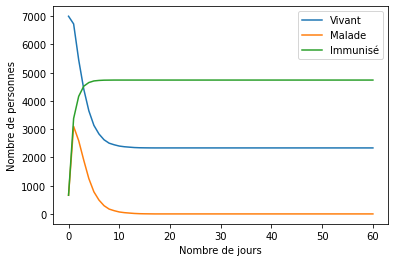

In [6]:
# Tracé de graphes :
x = []
for i in range(0,len(sma.plot_vivant)):
    x.append(i)

y = [sma.plot_vivant, sma.plot_malade, sma.plot_immunise]
labels = ['Vivant', 'Malade', 'Immunisé']

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)
plt.xlabel('Nombre de jours')
plt.ylabel('Nombre de personnes')
plt.legend(loc="upper right")
plt.show()

In [ ]:
import matplotlib.animation as ani

class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe
        self.immunise = [] # 1 = Oui, 0 = Non
        self.jour_malade = []

        self.plot_malade = []
        self.plot_vivant = []
        self.plot_immunise = []

        self.nx_animation = []

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[0.90,0.1])[0])
            if self.malade[i] == 1:
                self.immunise.append(1)
            else:
                self.immunise.append(0)
            self.jour_malade.append(0)

        # Initialisation des paramètres se basant sur les sources :

        # Pour l'âge : 
        # 0 = < 15 ans
        # 1 = entre 15 et 30 ans
        # 2 = entre 30 et 55 ans
        # 3 = > 55 ans

        # cf. pop-sexe-age-prop.xls 
        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Pour le sexe :
        # 0 = homme
        # 1 = femme

        # Pour le poids :
        # 0 = Dénutrition (IMC < 18.5)
        # 1 = Normal (18.5 > IMC > 25)
        # 2 = Surpoids (25 > IMC > 30)
        # 3 = Obésité (IMC > 30)

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Pour le groupe sanguin : 
        # 0 = A+
        # 1 = O+
        # 2 = B+ 
        # 3 = AB+
        # 4 = A-
        # 5 = O-
        # 6 = B-
        # 7 = AB-

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

        self.plot_malade.append(self.malade.count(1))
        self.plot_immunise.append(self.immunise.count(1))
        self.plot_vivant.append(self.vivant.count(1))

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            self.plot_malade.append(self.malade.count(1))
            self.plot_immunise.append(self.immunise.count(1))
            self.plot_vivant.append(self.vivant.count(1))
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")
        self.nx_animation.append(self.draw_graph("Jour " + str(self.tick)))

    def draw_graph(self,titre):
        color_map = []
        for node in self.graphe:
            if self.malade[node] == 1:
                color_map.append('red')
            else:
                if self.vivant[node] == 1: 
                    color_map.append('green')  
                else:
                    color_map.append('grey')


        size = []
        for node in self.graphe:
            size.append(self.graphe.degree(node))

        max_value = np.max(size)
        iterator = 0
        for value in size:
            size[iterator] = (value/max_value)*400
            iterator += 1

        fig = plt.figure()
        plt.axis('off')
        nx.draw(self.graphe, node_color=color_map, node_size=size)
        plt.title(str(titre))
        plt.savefig(f'./plot/{titre}.png')
        print(f"{titre} sauvegardé")
        return fig

class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

        self.alpha = 0.5 # contact
        self.beta = 0.9 # contamination
        self.gamma = 0.4 # décès
        self.delta = 0.01 # guérison
        self.incubation = 14 # période pendant laquelle le patient est malade

    def decide(self, tick) :
        j = self.id_number

        # On regarde si l'agent malade va guérir ou mourir
        if sma.malade[j] == 1 and sma.vivant[j] == 1:
            if sma.jour_malade[j] <= self.incubation:
                # Tous les jours, l'agent peut décéder :
                sma.vivant[j] = np.random.choice([0,1], 1, p=[self.gamma,1-self.gamma])[0]
                # S'il meurt, il n'est plus malade
                if sma.vivant[j] == 0:
                    sma.malade[j] = 0
                    sma.jour_malade[j] += self.incubation
                # ou guérir :
                sma.malade[j] = np.random.choice([0,1], 1, p=[self.delta,1-self.delta])[0]
                if sma.malade[j] == 0:
                    sma.jour_malade[j] += self.incubation
                # Puis, pour chaque malade on compte 1 jour de plus pour ce tour
                sma.jour_malade[j] += 1

        if sma.jour_malade[j] > self.incubation:
            sma.malade[j] = 0

        # Si l'agent j est vivant, on regarde s'il peut être contaminé :
        # Donc il faut qu'il soit sain et non immunisé
        if sma.vivant[j] == 1 and sma.immunise[j] == 0 and sma.malade[j] == 0:
            # On regarde tous ces liens et on garde uniquement les contacts
            liens = []
            contact = []
            for i in range(0,len(list(graph.edges(j)))):
                # On récupère les agents en lien avec notre agent
                # On les met dans un tableau
                liens.append(list(graph.edges(j))[i][1])
                # On récupère aléatoirement alpha % de ces personnes
            for k in range(int(self.alpha*len(liens))):
                valeur_contact = random.randint(0,int(self.alpha*len(liens)))
                contact.append(liens.pop(valeur_contact))
            # On fait en sorte que chaque j agents est au moins 1 contact :
            if (contact == []):
                contact.append(liens[len(liens)-1])
            
            # Pour chaque personnes restantes on regarde si elles sont malades
            for i in range(0,len(contact)):
                if sma.malade[contact[i]] == 1:
                    # Si un contact est malade, il y a beta % chances de contamination
                    sma.malade[j] = np.random.choice([0,1], 1, p=[1-self.beta,self.beta])[0]
                    if sma.malade[j] == 1:
                        # Notre agent devient immunisé à son tour
                        sma.immunise[j] = 1
                        #print(f"L'agent {j} s'est fait contaminé par l'agent {contact[i]}")
            
nb_agents = 700
nb_rounds = 14 
# Choix du type de graphe : 
graph = nx.barabasi_albert_graph(nb_agents, 1) # BA(n,m) avec n le nombre de noeuds et m le nombre d'arc ?
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph)

print(f"Il y a {nb_agents} agents et {nb_rounds} tours.")

sma.nx_animation.append(sma.draw_graph("Jour 0"))
# On lance le jeu
sma.run(nb_rounds)